<a href="https://colab.research.google.com/github/maxmatical/TMLS_NLP/blob/master/twitter__sentiment_RoBERTa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install git+https://github.com/fastai/fastai.git
!pip install pytorch-transformers

In [2]:
# Set up environment and download course-v3
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from fastai import *
from fastai.text import *
from fastai.utils.show_install import *
from fastai.callbacks import *
from fastai.metrics import *
from pytorch_transformers import RobertaTokenizer

from pytorch_transformers import RobertaTokenizer
roberta_tok = RobertaTokenizer.from_pretrained("roberta-base")

# import torch
show_install()



```text
=== Software === 
python        : 3.6.8
fastai        : 1.0.60.dev0
fastprogress  : 0.1.21
torch         : 1.3.1+cu100
nvidia driver : 418.67
torch cuda    : 10.0.130 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11441MB | Tesla K80

=== Environment === 
platform      : Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Thu Aug 8 02:47:02 PDT 2019
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once installe

In [0]:
# from fastai.callbacks import *
# from fastai import *

In [0]:
# import fastai
# fastai.device = torch.device('cpu')
# fastai.device

# EDA

In [0]:
df = pd.read_csv('testset1.csv')

In [5]:
print(len(df))

df.head(5)

5585


,id,name,date,text,location,sentiment
0,1.130000e+18,Evolutionomics,Sun May 19 23:57:10 +0000 2019,By combining short positions on #Gold $GOLD $G...,NaN,bearish
1,1.130000e+18,macrohedged,Sun May 19 23:55:02 +0000 2019,Here are the #Volatility levels for the majors...,England,unrelated
2,1.130000e+18,Evolutionomics,Sun May 19 23:54:06 +0000 2019,We have little insight into what will happen t...,NaN,neutral
3,1.130000e+18,Evolutionomics,Sun May 19 23:50:59 +0000 2019,"This brings us to #Gold miners. As a group, $G...",NaN,neutral
4,1.130000e+18,macrohedged,Sun May 19 23:50:04 +0000 2019,"Good morning Asia, here are the benchmark futu...",England,unrelated


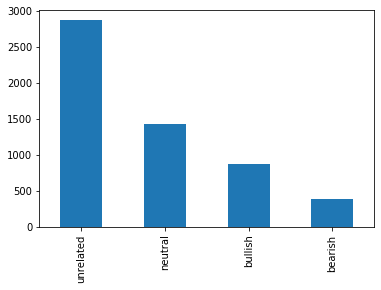

In [6]:
df['sentiment'].value_counts().plot(kind='bar')

Unrelated and neutral sentiments dominate the data currently (although this might not be the case in the future with the full dataset). It might be better to use a stratified sampling technique for classification

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
sss.get_n_splits(df['text'], df['sentiment'])

print(sss)



StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None)


In [8]:
train_idx, val_idx = next(sss.split(df['text'], df['sentiment']))

print(len(train_idx), len(val_idx))

4468 1117


Verifying that the stratified split preseves the distribution of the labels

In [0]:
df_train = df.iloc[train_idx, :]
df_val = df.iloc[val_idx, :]

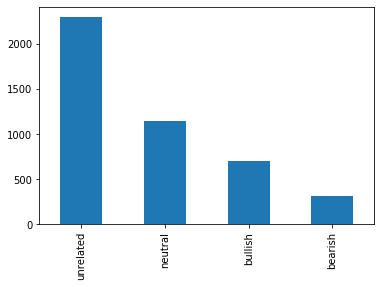

In [10]:
df_train['sentiment'].value_counts().plot(kind='bar')

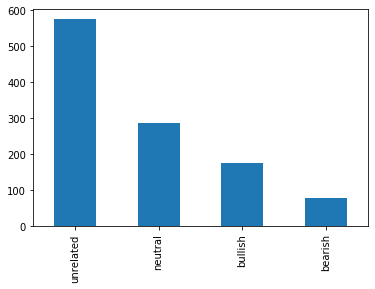

In [11]:
df_val['sentiment'].value_counts().plot(kind='bar')

Looks like the distribution of the labels in train and val are the same, so we can start modelling now

# Handling Imbalanced Data: Oversampling

In [0]:
df_class_bull = df_train[df_train['sentiment'] == 'bullish']
df_class_bear = df_train[df_train['sentiment'] == 'bearish']
df_class_neutral = df_train[df_train['sentiment'] == 'neutral']
df_class_unrelated = df_train[df_train['sentiment'] == 'unrelated']



In [0]:
print(len(df_class_unrelated))

2298


Want to oversample so that every class has 2298 counts

In [0]:
df_class_bull_over = df_class_bull.sample(len(df_class_unrelated), replace = True)
df_class_bear_over = df_class_bear.sample(len(df_class_unrelated), replace = True)
df_class_neutral_over = df_class_neutral.sample(len(df_class_unrelated), replace = True)


df_train_oversampled = pd.concat([df_class_bull_over, df_class_bear_over, df_class_neutral_over, df_class_unrelated], axis = 0)



Look at distribution of the labels in the oversampled data

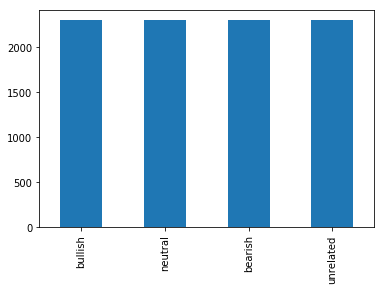

In [0]:
df_train_oversampled['sentiment'].value_counts().plot(kind='bar')

# RoBERTa

## Tokenizing and setting up databunch

In [0]:

class FastAiRobertaTokenizer(BaseTokenizer):
    def __init__(self, tokenizer: RobertaTokenizer, max_seq_len: int=128, **kwargs): 
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len 
    def __call__(self, *args, **kwargs): 
        return self 
    def tokenizer(self, t:str) -> List[str]: 
        return ["<s>"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["</s>"]

Creating tokenizer

In [0]:
# fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=256), pre_rules=[], post_rules=[])

roberta_tok = RobertaTokenizer.from_pretrained("roberta-base")

fastai_tokenizer = Tokenizer(tok_func=FastAiRobertaTokenizer(roberta_tok, max_seq_len=256), 
                             pre_rules=[], post_rules=[])


Loading vocab

In [0]:
# fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

path = Path()
roberta_tok.save_vocabulary(path)
with open('vocab.json', 'r') as f:
    roberta_vocab_dict = json.load(f)
    
fastai_roberta_vocab = Vocab(list(roberta_vocab_dict.keys()))

Setting up processors



In [0]:
# Setting up pre-processors
class RobertaTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
         super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)

class RobertaNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=fastai_roberta_vocab, **kwargs)


def get_roberta_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for Roberta
    We remove sos and eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original Roberta model.
    """
    return [RobertaTokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(vocab=vocab)]

## Creating a RoBERTa databunch

In [0]:
# Creating a Roberta specific DataBunch class
class RobertaDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training Roberta"
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=64, val_bs:int=None, pad_idx=1,
               pad_first=True, device:torch.device=None, no_check:bool=False, backwards:bool=False, 
               dl_tfms:Optional[Collection[Callable]]=None, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(pad_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, dl_tfms=dl_tfms, collate_fn=collate_fn, no_check=no_check)


class RobertaTextList(TextList):
    _bunch = RobertaDataBunch
    _label_cls = TextList


# loading the tokenizer and vocab processors
processor = get_roberta_processor(tokenizer=fastai_tokenizer, vocab=fastai_roberta_vocab)




In [0]:
bs = 16

# databunch method

# data_clas = RobertaDataBunch.from_df(".", df_train, df_val, 
#                   tokenizer=fastai_tokenizer,
#                   vocab=fastai_roberta_vocab,
#                   text_cols="text",
#                   label_cols='sentiment',
#                   bs=bs,
#                   collate_fn=partial(pad_collate, pad_first=False, pad_idx=0))

# data_clas.save('data_clas')

# creating datablock 

text_col = "text"
label_col = "sentiment"
data_clas = RobertaTextList.from_df(df, ".", cols=text_col, processor=processor) \
    .split_by_idxs(train_idx, val_idx) \
    .label_from_df(cols=label_col, label_cls=CategoryList) \
    .databunch(bs = bs, pad_first = False, pad_idx = 0)


In [59]:
data_clas.show_batch()

text,target
<s> Ġ ðĿ Ļ Ī ðĿ Ļ Ģ ðĿ Ļ Ī ðĿ Ļ Ĭ ðĿ Ļ į ðĿ Ļ Ħ ðĿ ĺ ¼ ðĿ Ļ ĩ Ġ ðĿ ĺ ¿ ðĿ ĺ ¼ ðĿ Ļ Ķ Ġ ðĿ ĺ ¿ ðĿ Ļ Ħ ðĿ Ļ İ ðĿ ĺ ¾ ðĿ Ļ Ĭ ðĿ Ļ Ĳ ðĿ Ļ ī ðĿ Ļ ı Ġ ðĿ Ļ Ĭ ðĿ Ļ ģ ðĿ Ļ,unrelated
<s> Ġ ðĿ Ĺ ļ ðĿ ĺ Ĥ ðĿ Ĺ ¿ ðĿ ĺ Ĥ ðĿ Ĺ Ľ ðĿ Ĺ ® ðĿ ĺ ĥ ðĿ Ĺ ² ðĿ Ĺ » Ġ ðĿ Ĺ ¡ ðĿ Ĺ ² ðĿ ĺ Ħ ðĿ ĺ Ģ ðĿ Ĺ ¹ ðĿ Ĺ ² ðĿ ĺ ģ ðĿ ĺ ģ ðĿ Ĺ ² ðĿ Ĺ ¿ Ġ# ðĿ Ł Ń ðĿ Ł ® ĠðŁ Ĺ ŀ,unrelated
<s> ĠDis rupted Ġof Ġthe Ġyear Ġaward Ġgoes Ġto Ġhol och ain . Ġ Ċ $ SP Y Ġ$ I WM Ġ$ Q Q Q Ġ$ X LI Ġ$ WH R Ġ$ MM M Ġ$ C AT Ġ$ BA Ġ$ TL T Ġ$ GL D Ġ$ CL _ F Ġ$ X LE Ġ$ X OM Ġ$ CV X Ġ$ XL F Ġ$ J PM Ġ$ GS Ġ$ X RT Ġ$,unrelated
<s> ĠðŁ Ĵ ¥ Week end ĠReview ĠVIDEO Ġ5 / 19 : Ġhttps :// t . co / N 5 M w ua U x A a Ċ Ċ $ SP Y Ġ$ I WM Ġ$ Q Q Q Ġ$ SM H Ġ$ IN TC Ġ$ NV DA Ġ$ XL N X Ġ$ L RC X Ġ$ X LI Ġ$ BA Ġ$ L MT Ġ$ DE Ġ$ M CD Ġ$,unrelated
<s> ĠMay ĠReturns : Ċ Bitcoin Ġ$ BTC : Ġ+ 51 % Ċ Vol atility Ġ$ V XX : Ġ+ 19 % Ċ Long ĠBonds Ġ$ TL T : Ġ+ 7 % Ċ Y en /$ : Ġ+ 3 % Ċ B onds Ġ$ AG G : Ġ+ 2 % Ċ Gold Ġ$ GL D : Ġ+ 2 % Ċ RE IT s Ġ$ V N Q : Ġ+ 0,neutral


## Using RoBERTa

Creating a custom model with custom number of heads for labels

In [0]:
from pytorch_transformers import RobertaModel

n_classes = 4
d_linear = 768
dropout_rate = 0.1
class CustomRobertatModel(nn.Module):
    def __init__(self,num_labels=n_classes, dropout_rate = dropout_rate, d_linear = d_linear):
        super(CustomRobertatModel,self).__init__()
        self.num_labels = num_labels
        self.dropout = dropout_rate
        self.d_linear = d_linear
        self.roberta = RobertaModel.from_pretrained("roberta-base")
        self.dropout = nn.Dropout(self.dropout)
        self.classifier = nn.Linear(self.d_linear, self.num_labels)
        
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _ , pooled_output = self.roberta(input_ids, token_type_ids, attention_mask)
        logits = self.classifier(pooled_output)        
        return logits


In [0]:
model = CustomRobertatModel()

### Classification

Not using mixed precision yet, do that after lr_find()

In [0]:
# learn.destroy()

learn = Learner(data_clas,
               model,
               loss_func = FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1),
               metrics = [accuracy])


Splitting bert for discriminative learning

In [0]:
# def bert_clas_split(self) -> List[nn.Module]:
    
#     bert = model.bert
#     embedder = bert.embeddings
#     pooler = bert.pooler
#     encoder = bert.encoder
#     classifier = [model.dropout, model.classifier]
#     n = len(encoder.layer)//3
#     print(n)
#     groups = [[embedder], list(encoder.layer[:n]), list(encoder.layer[n+1:2*n]), list(encoder.layer[(2*n)+1:]), [pooler], classifier]
#     return groups

# x = bert_clas_split(model)

In [0]:
# learn.split([x[0], x[1], x[2], x[3], x[5]]); # should this be x[4]?

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-05
Min loss divided by 10: 1.20E-04


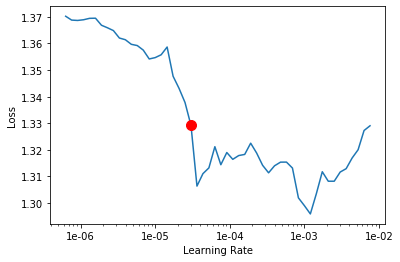

In [67]:
learn.lr_find()
learn.recorder.plot(suggestion = True, skip_end=15)

epoch,train_loss,valid_loss,accuracy,time
0,0.944346,0.852450,0.706356,06:08
1,0.707666,0.648707,0.852283,06:12
2,0.578633,0.591602,0.884512,06:16
3,0.514039,0.556887,0.905103,06:17
4,0.446343,0.561370,0.908684,06:17


Better model found at epoch 0 with accuracy value: 0.7063562870025635.
Better model found at epoch 1 with accuracy value: 0.8522828817367554.
Better model found at epoch 2 with accuracy value: 0.8845120668411255.
Better model found at epoch 3 with accuracy value: 0.9051029682159424.
Better model found at epoch 4 with accuracy value: 0.9086839556694031.


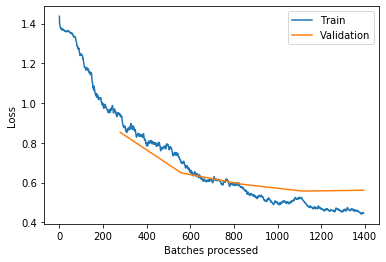

In [68]:
learn.to_fp16()

lr = 3e-5

"""Training without adjusting the momentum"""
learn.fit_one_cycle(5, 
                    lr, 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                                                 name='classifier_stage1')])
"""
Clipping momentum
"""


# learn.fit_one_cycle(10, 
#                     lr, 
#                     moms=(0.8,0.7),
#                     callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
#                                                  name='classifier_stage1')])

learn.recorder.plot_losses()

Additional training by unfreezing the network and applying discriminative learning rates

In [56]:
learn.load('classifier_stage1');
learn.unfreeze()


"""Training without adjusting the momentum"""
learn.fit_one_cycle(5, 
                    lr/10, 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                                                 name='classifier_final')])
"""
Clipping momentum
"""
# learn.fit_one_cycle(10, 
#                    slice(lr/(2.6**4),lr), 
#                    moms=(0.8,0.7),
#                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
#                                                  name='classifier_stage2')])

learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time
0,0.600493,0.666888,0.818263,07:07
1,0.625029,0.666262,0.820054,07:22


Better model found at epoch 0 with accuracy value: 0.8182632327079773.
Better model found at epoch 1 with accuracy value: 0.8200536966323853.


Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken p

KeyboardInterrupt: ignored

# Model Inference

In [0]:
learn = Learner(data_clas, 
                model)

# learn = Learner(data_clas,
#                model,
#                loss_func = FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1),
#                metrics = [accuracy])



learn.load('classifier_final', with_opt = False); # makesure learner  is a text_classifier_learner

learn.to_fp32() # bring back to fp32



learn.export(file = 'export_clas.pkl')



In [0]:
phrase = "$GLD will lose value over the next quarter"
learn.predict(phrase)


(Category bearish, tensor(0), tensor([0.6633, 0.1695, 0.1286, 0.0385]))

## Making batch predictions on new dataset

test_df can be loaded in directly from a csv file i.e. 1 days worth of collected tweets

In [0]:
# test_df = pd.read_csv('testset1.csv')

test_df = df_val
learn.data.add_test(test_df['text'])
preds, y, losses = learn.get_preds(ds_type=DatasetType.Test, with_loss = True)
# preds, y, losses = learn.get_preds(ds_type=DatasetType.Test, ordered=True, with_loss = True)


In [0]:

y_pred = torch.argmax(preds, dim= 1).numpy()


print(y_pred, len(y_pred))

pred_labels = []
for pred in y_pred:
    if pred == 0: 
        pred_labels.append('bearish')
    elif pred == 1:
        pred_labels.append('bullish')    
    elif pred == 2:
        pred_labels.append('neutral')
    elif pred == 3:
        pred_labels.append('unrelated')

[2 3 3 3 ... 3 3 2 3] 1117


## Visualizing predictions

visualize the count of predictions

1 = Bearish
2 = Bullish
3 = Neutral
4 = Unrelated

(array([326.,   0.,   0., 544.,   0.,   0.,  61.,   0.,   0., 186.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

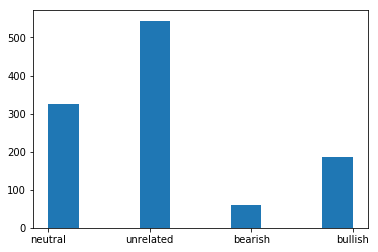

In [0]:
plt.hist(pred_labels)



The distribution of the predictions seems to be inline with the distribution of the val labels

View a confusion matrix of the predictions

y-axis is the true labels

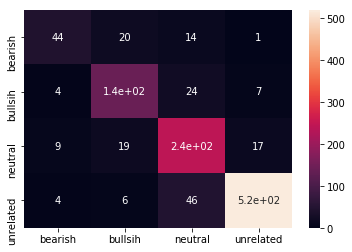

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sn
cm = confusion_matrix(df_val['sentiment'], pred_labels)

df_cm = pd.DataFrame(cm, index = ['bearish', 'bullsih', 'neutral', 'unrelated'],
                    columns = ['bearish', 'bullsih', 'neutral', 'unrelated'])

sn.heatmap(df_cm, annot=True)

Observations

Performance seems to match what AWD-LSTM is getting, slightly more bullish tweets categorized as bearish, but that could be due to the data split